# Оцифровка справок 405-05у. 

## Описание задачи

Организация, взаимодействующая с донорами крови, ведет учет активности доноров. Они присылают фото справок из пунктов сдачи крови, а работники организации вручную перепечатывают данные из этих справок в свои таблицы в формате csv. К этим данным относятся: дата сдачи крови, вид донорства (для каких целей сдается кровь), тип донации (безвозмездный или нет).</br>

**Цель**
Разработать алгоритм автоматической оцифровки данных из таблиц, напечатанных на медицинских справках формы 405-05у и содержащих информацию о датах донаций, виде и типе донорства. Из этой информации должен быть сформирован csv-файл.Для проведения этой работы, организация предоставила примеры справок и получаемых из них таблиц (в количестве 16 штук).

In [1]:
import cv2
import easyocr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re 
from sklearn.cluster import KMeans 

WIDTH = 3000 #ширина листа для рескейлинга

In [2]:
reader = easyocr.Reader(['ru']) # this needs to run only once to load the model into memory

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


## OCR: Оцифровка текста, получение сырых данных из сканов

Первичное распознавание всего текста на картинке: класс OCR занимается тем, что загружает картинку, проверяет ее размер. Если размер меньше 800px по ширине, то производится ресайз до 3000px. Эмпирически было выяснено, что если мелкую картинку увеличить, то качество OCR резко возрастает, а вот если картинка нормального размера, то ресайзом можно случайно качество OCR снизить. Поэтому размер меняется только для слишком маленьких фото. После этого производится OCR с помощью библиотеки easyOCR. На выходе получается массив данных: список опознанных строк.

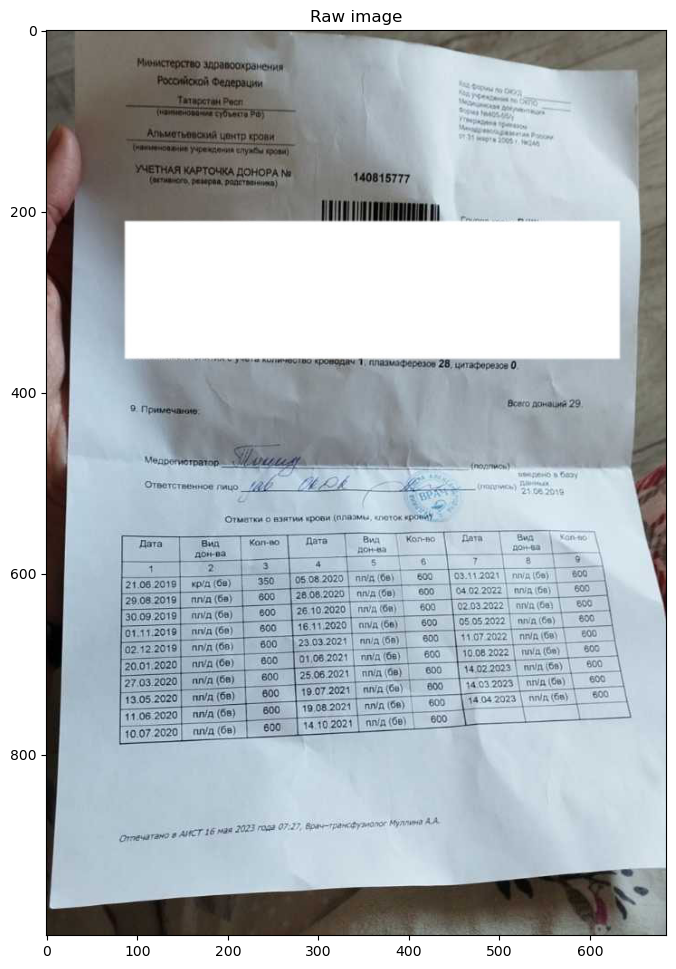

In [3]:
#Вот такую картинку возьмем для иллюстрации работы алгоритма
path = 'raw\\141899 .jpg'
path_csv =  'csv\\141899.csv'
image = cv2.imread(path)
image = np.ascontiguousarray(image[..., [2, 1, 0]])
plt.figure(figsize=(8,15))
plt.imshow(image)
plt.title('Raw image')
plt.show()

In [4]:
class OCR():
    def __init__(self, image_path):
        self.image_path = image_path
        
    def execute(self):
        self.read_image()
        self.rescale()
        self.easyOCRed()
        
    # загрузка картинки    
    def read_image(self):
        self.image = cv2.imread(self.image_path)
        self.image = np.ascontiguousarray(self.image[..., [2, 1, 0]])
        
    # подгон размера картинки под ширину 3000px, если она слишком мелкая (<800px)
    def rescale(self):
        h, w, c = self.image.shape
        if w < 800:
            ratio = h / w
            # Set rows and columns
            width = WIDTH
            height = int(ratio * width)
            points = (width, height)
            # resize the image
            self.image = cv2.resize(self.image, points, interpolation = cv2.INTER_LINEAR)
        return self.image
    
    # распознавание всего текста на картинке
    def easyOCRed(self):
        return reader.readtext(self.image, detail = 0)

In [5]:
# создаем объект класса и получаем результат OCR
ocr = OCR(path)
ocr.execute()
ocred = ocr.easyOCRed()
print('Результат easyOCR: распознанный текст на картинке')
print(ocred)

Результат easyOCR: распознанный текст на картинке
['Нянистер 70 чипав окра}еуня', 'НоССлио 9й @еДерацкм', 'шшаиРоап', '1', '0п', '^льч-(ски цштр кгани', 'Птинса  нэР ДОнип Епу=6', 'ЖЕТНАЯ КАРТОЧА ДОНОРАМ;', '1-лллг', '1140815777', 'паоотводродотач', 'Плачазвераюа 28; цитвфорелоа 0', 'Влто данаша 29', 'Пгечлшо', 'Медоотатрятар', 'шш', 'Чмг', 'иг ю', '<ш;', 'ОтьстСтшсысе <ицо', '{патчс) Е', '330', '2*сюе', 'Отматм 0 вантии ~роаы (пПаам; , "латст~р7ъ:)', 'Кол ', 'Швтв', 'Вул', 'нол-1о', 'Ляп', 'Ем₽', '<ат', 'Дпта', 'Вип', '{,т 5а', 'Аон4 ', '{он- на', '6', '5', '2', '350', '05,€ъ 2070', 'лпд {бы}', '€0', '0:.11207]', 'плуд (6а))', '619', '21.06 2019', '#[д (Од)', '651', '600', '26 08 2020', 'п.д {6ц)', '670', '64622072', 'плд [€9]', '29 05 2019', 'ппд (6а)', '609', '02 032022', 'П.Уп (Ов }', "'ег0", '30.092019', 'ПтУд (6а)', '500', '26 10.2020', 'Ппмноп)', '76.11,2029', 'пмп (66)', '600', '[5 05 2022', 'па (65)', '600', '0111 2019', 'ппуд (69)', '600', '605', 'и1 07202', 'пл/п (6а )', 'Е0

## Поиск и получение полезных данных из оцифрованного текста

Вытащим из полученной кучи только то, что нам надо: таблицу с данными о донации (дата, класс крови, тип донации). Критерием поиска записей будут являться регулярные выражения и строго последовательное расположение строк, соответсвующих дате, типу донорства и количеству сданной крови. Проверка на соответствие проводится с помощью регулярных выражений и является нестрогой, для того, чтобы пропустить единичные ошибки детекции символов. Например, с датой ассоциируется такая строка, в которой пары непробельных символов чередуются с последовательностью символов, которые не являются цифрами. Далее:
- Найденные строки сшиваются в таблицу и далее каждая колонка этой таблицы подлежит более кропотливой обработке:
- Даты обрабатываются таким образом, чтобы из них по отдельности вытащить день, месяц и год.
- Вид сданной крови и тип донорства также определяются с помощью регулярных выражений, учитывающих возможные промахи в OCR.
- Из очищенных и отфильтрованных данных (дата, вид крови и тип донации) формируется таблица в формате pd.DataFrame. Эта таблица сортируется по дате. Для автоматической сортировки даты в виде кортежа из трех чисел, год и день меняются местами, а после сортировки возвращаются обратно и весь кортеж сшивается в единую строку.

In [6]:
# регулярные выражения для того, чтобы найти дату, тип донации и количество крови
datetime = r'\w{2}\D{0,3}\w{2}\D{0,3}\w{2,4}'
blood_type = r'.{3,5}[({[].{1,3}[)}\]]'
blood_amount = r'\S{1,4}'

class FindTable():
    def __init__(self, easyOCRed):
        self.easyOCRed = easyOCRed
        
    def execute(self):
        self.extract_table()
        self.datetime_clean()
        self.blood_type()
        self.donation_type()
        self.create_dataframe()
    
    # получаем полезные данные (дата, тип донации и количество крови, координата верхнего левого угла ячейки с датой)
    # из полного списка опознанных строк, полученного после OCR скана с помощью easyOCR
    def extract_table(self): 
        self.table = []
        for i in range(len(self.easyOCRed)-2):
            text0 = self.easyOCRed[i]
            text1 = self.easyOCRed[i+1]
            text2 = self.easyOCRed[i+2]
            if (
                re.fullmatch(datetime, text0) and    # если элемент списка смахивает на дату
                re.fullmatch(blood_type, text1) and  # а следующий элемент - это текст и потом что-то короткое в скобочках
                re.fullmatch(blood_amount, text2)    # а еще следующий - это 1-4 символа....  То это то, что нам надо! 
            ):
                self.table.append([text0 ,text1, text2])  # берем!
        return self.table

    # выделение и форматирование даты
    def datetime_clean(self):
        pattern = r'\d\d'                             # будем искать пару чисел. Это день или месяц.
        self.datetime = []
        for row in self.table:
            string = row[0]                        # отщипнули то, что мы посчитали датой в методе extract_table()
            try:
                day = re.search(pattern, string)[0]   # если нашли пару чисел, то это день
            except:
                self.datetime.append(('-', '-', '-'))  # если не нашли пару чисел, то и не понятно какая дата
                continue
            index_day = string.find(day)               # позиция (индекс), где был найден день от даты
            string = string[index_day+2:]              # отрежем день от строки с датой и продолжим дальше с ней работать
            try:
                month = re.search(pattern, string)[0]  # нашел опять пару чисел? это месяц.
            except: 
                self.datetime.append((day, '-', '-'))  # а если не нашел, то запишем в конечном результате только день
                continue
            index_month = string.find(month)
            string = string[index_month+2:]            # опять подрезаем строку, осталось найти год
            try:
                year = re.search(r'\d{4}', string)[0]  # ищем год в виде четырех цифр подряд
                string = ''
                self.datetime.append((day, month, year))
                continue
            except:
                try:
                    year = re.search(r'\d{2}', string)[0] # если не нашли год в виде четырех цифр, то поищем в виде двух
                    self.datetime.append((day, month, year))
                    continue
                except:
                    self.datetime.append((day, month, '-')) # а если вообще год не нашли, то запишем только день и месяц
                    continue
            return self.datetime

    # определяем какую кровь сдали
    def blood_type(self):
        blood_type = {              # определяем по первой букве в записи
            'п': 'Плазма',
            'к': 'Цельная кровь',
            'т': 'Тромбоциты',
            'ц': 'Цельная кровь'
        }
        self.bloodtype = []
        for row in self.table:
            string = row[1]
            try:
                self.bloodtype.append(blood_type[string[0].lower()])
                continue
            except:
                self.bloodtype.append('-')
                continue
        return self.bloodtype

    # определение типа донации (бесплатно сдал?)
    def donation_type(self):
        pattern = r'[({[].*[бпс60о].*[в3здь569а0oп]'
        self.donationtype = []
        for row in self.table:
            string = row[1]
            try:
                re.search(pattern, string.lower())[0]
                self.donationtype.append('Безвоздмездно')
            except:
                self.donationtype.append('-')
        return self.donationtype


    # склеить почищенные данные в финальную табличку и отсортировать ее по дате
    # для сортировки по дате: поменять местами год и день        
    def create_dataframe(self):
        df = pd.DataFrame({
            'Дата донации': self.datetime,
            'Класс крови': self.bloodtype,
            'Тип донации': self.donationtype
            }
            #, index =  dates
        )

        df['Дата донации'] = (df['Дата донации'].apply(change)) # меняем местами год и день в дате
        df = df.sort_values(by='Дата донации', axis=0)          # сортируем (сначала по дате, потом месяцу и потом дню)
        df['Дата донации'] = (df['Дата донации'].apply(change)) # меняем обратно и возвращаем на место год и день
        df['Дата донации'] = df['Дата донации'].apply(lambda x: '.'.join(x)) # сшиваем дату в единую строку
        return df

# функция, меняющая местами год и день, нужна для сортировки полученной таблицы по датам
def change(x):
    x = list(x)
    x[0], x[2] = x[2], x[0]
    return x

Создание экземпляра класса и получение таблицы

In [7]:
find_table = FindTable(ocred)
find_table.execute()
df = find_table.create_dataframe()
extracted_table = find_table.extract_table()

In [8]:
print('полезные данные:')
display(extracted_table)
print('\n\nсшитый и отсортированный датасет из этих данных:')
df.reset_index(drop=True)

полезные данные:


[['21.06 2019', '#[д (Од)', '651'],
 ['26 08 2020', 'п.д {6ц)', '670'],
 ['29 05 2019', 'ппд (6а)', '609'],
 ['02 032022', 'П.Уп (Ов }', "'ег0"],
 ['30.092019', 'ПтУд (6а)', '500'],
 ['76.11,2029', 'пмп (66)', '600'],
 ['0111 2019', 'ппуд (69)', '600'],
 ['и1 07202', 'пл/п (6а )', 'Е0О'],
 ['0212.2019', 'пп л (65 )', '600'],
 ['25 03.2021', 'пп д (6п)', 'с0с'],
 ['20,01 2070', 'ппуд (60 )', '600'],
 ['14022023', 'пд (60)', 'вса'],
 ['25.06 2021', 'ппд (Ов}', '600'],
 ['7106 2020', 'ппад (Ов}', '(66)']]



сшитый и отсортированный датасет из этих данных:


,Дата донации,Класс крови,Тип донации
0,07.20.-,Плазма,Безвоздмездно
1,29.05.2019,Плазма,Безвоздмездно
2,21.06.2019,-,Безвоздмездно
3,30.09.2019,Плазма,Безвоздмездно
4,01.11.2019,Плазма,Безвоздмездно
5,02.12.2019,Плазма,Безвоздмездно
6,71.06.2020,Плазма,Безвоздмездно
7,26.08.2020,Плазма,-
8,25.03.2021,Плазма,Безвоздмездно
9,25.06.2021,Плазма,Безвоздмездно


In [9]:
# сохранение полученной таблицы

def save_csv(path, df):
    df.to_csv(path, index=False)

## Accuracy

Вычисление точности распознавания фотографии реализуется так:
- сравниваются полученный и "истинный" (т.е. полученный от заказчика) датасеты. Формируется список, в котором каждой строке полученного датасета ставится в соответствие строка "истинного".
- для каждой ячейки считается точность распознавания. Посимвольно сравнивается содержимое, и подсчитывается соотношение количества совпавших символов к общему числу символов в ячейке.
- Полученные значения точности для всех ячеек усредняются с учетом того, что есть полностью нераспознанные строки.

In [10]:
df                             # предсказанная таблица
truth = pd.read_csv(path_csv)  # истинная таблица

In [11]:
display(df)
truth

,Дата донации,Класс крови,Тип донации
7,07.20.-,Плазма,Безвоздмездно
2,29.05.2019,Плазма,Безвоздмездно
0,21.06.2019,-,Безвоздмездно
4,30.09.2019,Плазма,Безвоздмездно
6,01.11.2019,Плазма,Безвоздмездно
8,02.12.2019,Плазма,Безвоздмездно
13,71.06.2020,Плазма,Безвоздмездно
1,26.08.2020,Плазма,-
9,25.03.2021,Плазма,Безвоздмездно
12,25.06.2021,Плазма,Безвоздмездно


,ID,ID пользователя,Класс крови,Дата донации,Дата добавления донации,Тип донации,Регион,Место стадчи,Статус донации,Есть справка
0,87330,141899,Цельная кровь,21.06.2019,18.11.2020,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да
1,213527,141899,Плазма,29.08.2019,16.05.2023,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да
2,213528,141899,Плазма,30.09.2019,16.05.2023,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да
3,213529,141899,Плазма,01.11.2019,16.05.2023,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да
4,213530,141899,Плазма,02.12.2019,16.05.2023,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да
5,213713,141899,Плазма,20.01.2020,17.05.2023,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да
6,213725,141899,Плазма,27.03.2020,17.05.2023,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да
7,213718,141899,Плазма,13.05.2020,17.05.2023,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да
8,213719,141899,Плазма,11.06.2020,17.05.2023,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да
9,213720,141899,Плазма,10.07.2020,17.05.2023,Безвозмездно,"Россия, Татарстан, Альметьевск",703,Принята,Да


In [12]:
class accuracy():
    def __init__(self, predicted_table, true_table):
        self.df = predicted_table
        self.truth = true_table
        
    def execute(self):
        self.find_overlaying_rows()
        self.accuracy()
    
    # собираем попарно строки полученного и истинного датасетов
    def find_overlaying_rows(self):
        truth = self.truth.copy() 
        data = {'Дата донации': '-',
                'Класс крови': '-',
                'Тип донации': '-'}
        plug = pd.Series(data, index=['Дата донации', 'Класс крови', 'Тип донации']) #затычка
        interference = []             # тут будут храниться пары "одинаковых" строк
        last_index = -1
        for i in self.df.index:
            date = self.df.loc[i]['Дата донации']
            found = truth.loc[truth['Дата донации'].str.contains(date[0:3])] # в оригинальной таблице вот такие строки содержат тот же день опознанной даты
            try:
                interference.append((self.df.loc[i], truth.loc[found.index[0]])) # сшиваем вместе строки и добавляем в список
                last_index = int(found.index[0])                                 # запомнили индекс строки из истинного датасета.
                truth = truth.drop([int(found.index[0])] )                       # выкинули ту строчку, которую сочли распознанной
            except:
                try:
                    interference.append((self.df.loc[i], truth.loc[last_index + 1])) # если не удалось найти соответствия, то поставим следующую строку за той, которую опознали в прошлый раз
                except:
                    continue
                continue
        self.interference = interference
        return self.interference
    
    #расчет accuracy для одного распознанного документа
    def accuracy(self):
        fail = np.zeros(len(self.truth) - len(self.interference)) #сколько строк вообще не опозналось
        acc_all = []
        for i in ['Дата донации', 'Класс крови', 'Тип донации']:
            acc = []
            for n in self.interference:
                acc.append(one_cell_accuracy(n[0][i], n[1][i]))
            acc.extend(fail)
            acc_all.append(np.mean(acc))
        return np.mean(acc_all)    
    
# функция, которая вычисляет точность для одной ячейки
def one_cell_accuracy(predicted_cell_str, true_cell_str):
    ziped = list(zip(predicted_cell_str, true_cell_str)) # посимвольно слепили содержимое двух ячеек (две строки)
    overlap = 0
    for i in ziped:
        if i[0] == i[1]:   # если символы совпадают, то 
            overlap += 1   # счетчик увеличивается
    acc = overlap / len(ziped)
    return acc

Создаем экземпляр класса  и получаем accuracy

In [13]:
acc = accuracy(df, truth)
acc.execute()
print(f'Точность (accuracy) определения таблицы в документе {path} составила', round(acc.accuracy(), 2))

Точность (accuracy) определения таблицы в документе raw\141899 .jpg составила 0.35


### А теперь прогоним алгоритм по всем документам

In [14]:
csvnames = {0: '141899.csv',  
            1: '204119.csv',  
            2: '213950.csv',  
            3: '225629.csv',  
            4: '227414.csv',  
            5: '228963.csv',  
            6: '231820.csv',  
            7: '233749.csv',  
            8: '236000.csv',  
            9: '238716.csv',  
            #10: '240493.csv',   # такого файла почемуто нет
            10: '243478.csv',  
            11: '245365.csv',  
            12: '254586.csv',  
            13: '256578.csv',  
            14: '256838.csv'   
           }

jpgnames = {0: '141899 .jpg',  
            1: '204119 .jpg',   
            2: '213950.jpg',   
            3: '225629 .jpg',   
            4: '227414.jpg',    
            5: '228963 .jpg',   
            6: '231820 .jpg',   
            7: '233749 .jpg',   
            8: '236000 .jpg',   
            9: '238716.jpg',   
            #10: '240493.jpg', 
            10: '243478 .jpg',  
            11: '245365 .jpg',  
            12: '254586 .jpg',  
            13: '256578 .jpg',  
            14: '256838.jpg'    
           }

In [15]:
final_accuracy = []

# прогоним все картинки!
for N in range(15):
    path = 'raw//' + jpgnames[N]
    ocr = OCR(path)
    ocr.execute()
    ocred = ocr.easyOCRed()
    
    find_table = FindTable(ocred)
    find_table.execute()
    df = find_table.create_dataframe() #Предсказанная таблица
    extracted_table = find_table.extract_table()
    truth = pd.read_csv('csv//' + csvnames[N])  #истинная таблица

    acc = accuracy(df, truth)
    acc.execute()
    doc_accuracy = round(acc.accuracy(), 2)
    final_accuracy.append(doc_accuracy)
    print('файл:', path)
    print('найдено строк', len(df))
    print('accuracy:', doc_accuracy, '\n')

файл: raw//141899 .jpg
найдено строк 14
accuracy: 0.35 

файл: raw//204119 .jpg
найдено строк 5
accuracy: 0.69 

файл: raw//213950.jpg
найдено строк 21
accuracy: 0.79 

файл: raw//225629 .jpg
найдено строк 11
accuracy: 0.48 

файл: raw//227414.jpg
найдено строк 19
accuracy: 0.75 

файл: raw//228963 .jpg
найдено строк 1
accuracy: 0.01 

файл: raw//231820 .jpg
найдено строк 13
accuracy: 0.83 

файл: raw//233749 .jpg
найдено строк 18
accuracy: 0.7 

файл: raw//236000 .jpg
найдено строк 5
accuracy: 0.83 

файл: raw//238716.jpg
найдено строк 36
accuracy: 0.83 

файл: raw//243478 .jpg
найдено строк 26
accuracy: 0.22 

файл: raw//245365 .jpg
найдено строк 35
accuracy: 0.76 

файл: raw//254586 .jpg
найдено строк 11
accuracy: 0.75 

файл: raw//256578 .jpg
найдено строк 0
accuracy: 0.0 

файл: raw//256838.jpg
найдено строк 19
accuracy: 0.43 



In [16]:
accuracy_all_photos = final_accuracy
print('Точность метода составляет')
np.mean(accuracy_all_photos)

Точность метода составляет


0.5613333333333334

## Итог

Средняя точность метода - 56%.
Из 15 фотографий:
- 8 фото распознаны более, чем на 70%
- 2 фото не распознаны

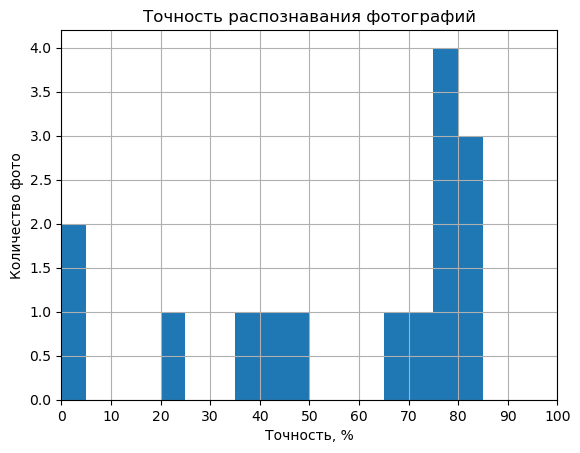

In [18]:
plt.hist(np.array(accuracy_all_photos)*100, range=(0, 100), bins=20)
plt.title('Точность распознавания фотографий')
plt.xlim(0, 100)
plt.ylabel('Количество фото')
plt.xlabel('Точность, %')
plt.xticks(range(0, 101, 10))
plt.grid()
plt.show()